In [1]:
cd ..

/Users/joeranbosma/stack/Projects/MLiP/code/hw1


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy
import wandb

from flow import evaluate_trained_model, generators_from_prep, preview_from_prep
from helper import generator_wrapper
from starter_eda_model_funcs import MultiOutputDataGenerator
from preprocessing import perform_preprocessing

# setup figure params
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 14})
plt.rcParams["savefig.bbox"] = 'tight'

# Final ROI-padding plot

## Obtain metrics

In [3]:
run_list = [
    ( 32,  5, 'ze3z7dyp'), # note: 40 epochs
    ( 64,  5, 'f5td0zg7'),
    ( 96,  5, 'w26kkxhb'),
    (128,  5, 'uq585thx'), # note: final 14 epochs of run with 30 epochs
    
    ( 32,  5, 'ze3z7dyp'), # note: 40 epochs
    ( 64, 10, 'i75sv5ht'),
    ( 96, 15, 'mau7sewk'),
    (128, 21, 'so8bbr9j'),
]

In [5]:
api = wandb.Api()
run = api.run("/joeranbosma/mlip/runs/mau7sewk")
run.history().head()

,val_out_consonant_loss,out_consonant_loss,_step,loss,val_out_vowel_loss,out_vowel_loss,_runtime,val_out_root_loss,out_root_acc,lr,val_out_root_acc,epoch,val_out_vowel_acc,val_out_consonant_acc,out_vowel_acc,out_root_loss,_timestamp,val_loss,out_consonant_acc,val_global_accuracy
0,0.321878,0.812092,0,2.334759,0.435072,1.052457,11836.078935,1.781920,0.131081,0.001,0.467554,0,0.854472,0.897959,0.627420,3.735684,1.581735e+09,1.080197,0.727261,0.671835
1,0.161809,0.336749,1,0.902803,0.170892,0.458449,12196.606843,0.550738,0.593556,0.001,0.842730,1,0.949133,0.949455,0.848248,1.408006,1.581735e+09,0.358544,0.887989,0.895717
2,0.120298,0.216848,2,0.483415,0.120996,0.270604,12556.651664,0.406677,0.795252,0.001,0.884704,2,0.966518,0.962614,0.916936,0.723363,1.581736e+09,0.263662,0.930892,0.924874
3,0.097796,0.171225,3,0.362177,0.104320,0.206526,12916.669250,0.331823,0.849885,0.001,0.908849,3,0.972152,0.970260,0.939298,0.535732,1.581736e+09,0.216440,0.946620,0.939702
4,0.085209,0.143800,4,0.300363,0.098144,0.174012,13276.765179,0.280902,0.875843,0.001,0.923780,4,0.974325,0.975452,0.950011,0.441836,1.581736e+09,0.186289,0.956559,0.949468


In [6]:
acc_list = []

for roi_size, pad_size, run_id in run_list:
    run = api.run("/joeranbosma/mlip/runs/{}".format(run_id))
    acc_list.append((roi_size, pad_size, run.history()['val_global_accuracy'].values))

**Filter accuracies to only include the final 10 epochs, but not those after 30 epochs**

In [7]:
for i, (roi_size, pad_size, acc) in enumerate(acc_list):
    acc = acc[:30][-10:]
    acc_list[i] = roi_size, pad_size, acc

In [8]:
# should all have been on a Tesla P100-PCIE-16GB

runtime_list = [
    ( 32 + 5,   4482), # 1h 39m 36s + interpolation from 40 to 30 epochs
    
    ( 64 + 5,   6753),
    ( 64 + 10, 208*30), # based on logs
    
    ( 96 + 5,  10219),
    ( 96 + 15, 360*30), # based on logs
    
    (128 + 5,  15595), # 2h 27m 17s + extrapolation from epoch 17
    (128 + 21,   19817), # good measurement, very good agreement with log of 660*30
]

## Plot

In [45]:
def plot_acc_gain(scores, labels, baseline, label_rotation=0, ax=None, fn=None, color='C0'):
    try:
        scores = np.array(scores)
    except:
        pass # pray
    
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # check input shape
    if isinstance(scores[0], int):
        means = scores
        stds  = None
    else:
        means = np.mean(scores, axis=-1)
        stds  = np.std(scores, axis=-1)
    
    # bar plot with the accuracy gain as height
    y = means - means[baseline]
    ax.bar(range(len(labels)), height=y, yerr=stds, color=color)
    # write total accuracy above bars
    for i, (v, a) in enumerate(zip(y, means)):
        ax.text(i, v+np.max(stds), f"{a:,.2%}", va='bottom', ha='center', fontweight='bold')

    # set labels of individual runs
    ax.set_xticklabels(labels, rotation=label_rotation)
    ax.set_xticks(range(len(labels)))
    
    # hide top and right axis
    # Hide the right and top spines
    if False:
        for loc in ['right', 'top', 'bottom']:
            ax.spines[loc].set_visible(False)
        ax.axhline(0, color='k')
    else:
        for loc in ['right', 'top']:
            ax.spines[loc].set_visible(False)
        ax.set_ylim(0)
    
    # Set yticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Global validation accuracy gain")

    if fn:
        f.tight_layout()
        f.savefig('{fn}'.format(fn=fn))
        plt.show()

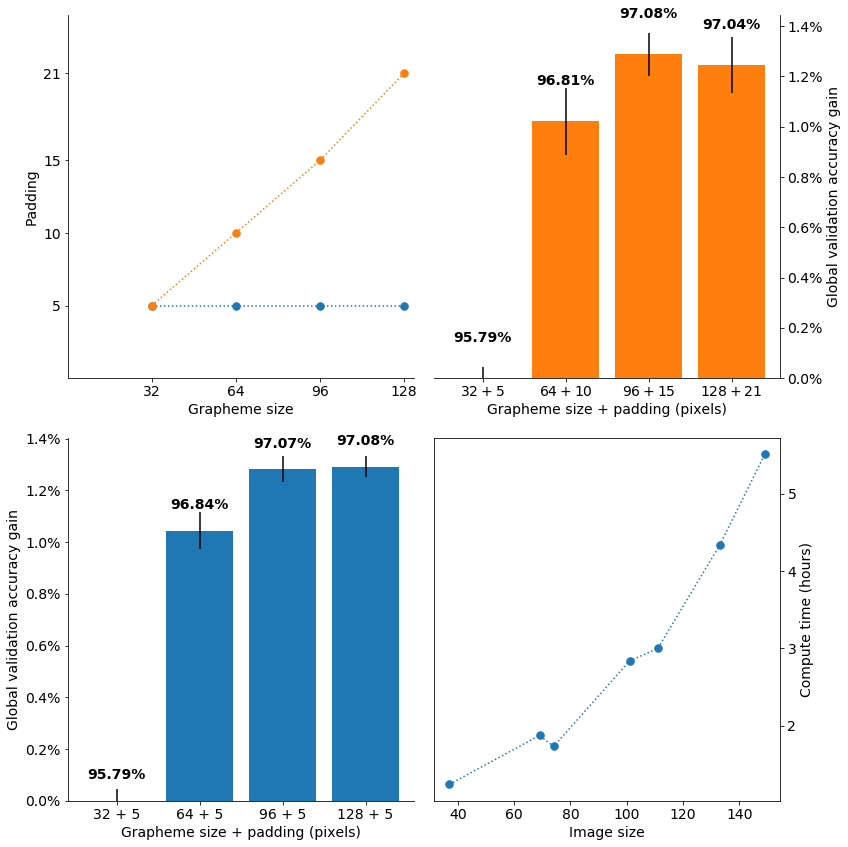

In [73]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

ax = axes[0, 0]
x = [32, 64, 96, 128]
y = [5, 10, 15, 21]
ax.plot(x, [5, 5, 5, 5], '.:', ms=15)
ax.plot(x, y, '.:', ms=15)
ax.set_xlabel('Grapheme size')
ax.set_ylabel('Padding')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlim(0, max(x)+4)
ax.set_ylim(0, max(y)+4)
for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)

ax = axes[0, 1]
scores = [a[2][-5:] for a in acc_list[-4:]]
labels = ["${} + {}$".format(a[0], a[1]) for a in acc_list[-4:]]
plot_acc_gain(scores, labels, baseline=0, label_rotation=0, ax=ax, color='C1')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.set_xlabel("Grapheme size + padding (pixels)")

ax = axes[1, 0]
scores = [a[2][-5:] for a in acc_list[:4]]
labels = ["{} + {}".format(a[0], a[1]) for a in acc_list[:4]]
plot_acc_gain(scores, labels, baseline=0, label_rotation=0, ax=ax)
ax.set_xlabel("Grapheme size + padding (pixels)")

ax = axes[1, 1]
x = [a[0] for a in runtime_list]
y = [a[1]/3600 for a in runtime_list]
ax.plot(x, y, '.:', ms=15)
ax.set_xlabel("Image size")
ax.set_ylabel("Compute time (hours)")

for ax in [axes[0, 1], axes[1, 1]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

f.tight_layout()
f.savefig("Figures/global_val_acc_gain")
plt.show()

# Same plot but with max val acc instead of mean

In [66]:
def plot_max_acc_gain(scores, labels, baseline, label_rotation=0, ax=None, fn=None, color='C0'):
    try:
        scores = np.array(scores)
    except:
        pass # pray
    
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    maxs = np.max(scores, axis=-1)
    mins = np.min(scores, axis=-1)
    
    # bar plot with the accuracy gain as height
    y = maxs - maxs[baseline]
    yerr = np.zeros(shape=(2, len(y)))
    yerr[0] = maxs-mins
    ax.bar(range(len(labels)), height=y, yerr=yerr, color=color)
    # write total accuracy above bars
    for i, (v, a) in enumerate(zip(y, maxs)):
        ax.text(i, v, f"{a:,.2%}", va='bottom', ha='center', fontweight='bold')

    # set labels of individual runs
    ax.set_xticklabels(labels, rotation=label_rotation)
    ax.set_xticks(range(len(labels)))
    
    ax.set_ylim(0)
    
    # Set yticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Global max. validation accuracy gain")

    if fn:
        f.tight_layout()
        f.savefig('{fn}'.format(fn=fn))
        plt.show()

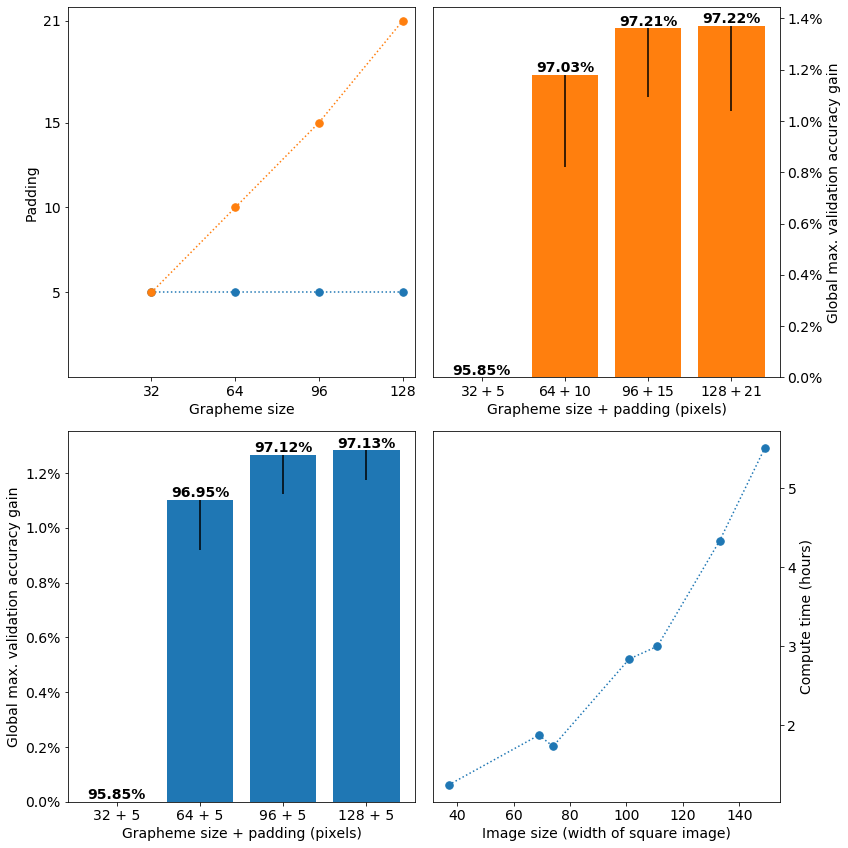

In [74]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

ax = axes[0, 0]
x = [32, 64, 96, 128]
y = [5, 10, 15, 21]
ax.plot(x, [5, 5, 5, 5], '.:', ms=15)
ax.plot(x, y, '.:', ms=15)
ax.set_xlabel('Grapheme size')
ax.set_ylabel('Padding')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlim(0)#, max(x)+8)
ax.set_ylim(0)#, max(y)+4)

ax = axes[0, 1]
scores = [a[2][-5:] for a in acc_list[-4:]]
labels = ["${} + {}$".format(a[0], a[1]) for a in acc_list[-4:]]
plot_max_acc_gain(scores, labels, baseline=0, label_rotation=0, ax=ax, color='C1')
ax.set_xlabel("Grapheme size + padding (pixels)")

ax = axes[1, 0]
scores = [a[2][-5:] for a in acc_list[:4]]
labels = ["{} + {}".format(a[0], a[1]) for a in acc_list[:4]]
plot_max_acc_gain(scores, labels, baseline=0, label_rotation=0, ax=ax)
ax.set_xlabel("Grapheme size + padding (pixels)")

ax = axes[1, 1]
x = [a[0] for a in runtime_list]
y = [a[1]/3600 for a in runtime_list]
ax.plot(x, y, '.:', ms=15)
ax.set_xlabel("Image size (width of square image)")
ax.set_ylabel("Compute time (hours)")

for ax in [axes[0, 1], axes[1, 1]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

f.tight_layout()
f.savefig("Figures/global_max_val_acc_gain")
plt.show()